In [121]:
# Require libraries
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import savgol_filter
from tsmoothie.smoother import LowessSmoother


In [122]:
# Function for pixel to degree conversion

# for stimulus
def px_deg_sti(data):
    time_sti = []
    pos_sti = []
    for y in data[1]:
        new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
        pos_sti.append(new_y)

    for x in range(1,len(pos_sti)+1):
        new_x = round((1/60)*x,4) # for monitor with screen refresh rate( 60 Hz)
        time_sti.append(new_x)
    return time_sti,pos_sti
    
# for eye
def px_deg_eye(data,dominant_eye):
    time_eye = []
    pos_eye = []
    if dominant_eye == 'right':
        for y in data['GazePointRightX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    elif dominant_eye == 'left':
        for y in data['GazePointLeftX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    for x in range(1,len(pos_eye)+1):
        new_x = round((1/300)*x,4) # for tobii's eye tracker with 300 Hz sampling rate
        time_eye.append(new_x)
    return time_eye,pos_eye

In [129]:
# Create path for healthy control(HC)
path = os.getcwd()
dirname = os.path.dirname(path)
option = ['URLStart','URLEnd'] # This is the values in the Studio event column where stimuli start and end events from dataset
directory_hc  = dirname+"/data/subjects/HC"
s_path = dirname+"/result/4_dps/s_hc" # single gasf path for hc
c_path = dirname+"/result/4_dps/c_hc" # combine gasf path for pd
files_hc = glob.iglob(directory_hc+'/[!.]*') # skip unwanted file such as .DS_Store file
right = 'right'
left = 'left'

In [130]:
# Remove outlier
def remove_outlier_IQR(df,i):
    Q1=df[i].quantile(0.25)
    Q3=df[i].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[i][~((df[i]<(Q1-1.5*IQR)) | (df[i]>(Q3+1.5*IQR)))]
    return df_final

In [132]:
# Blink detection and interpolation
def blink_nan(series,i):
    df = pd.DataFrame(series)
    df['new'] = ((df[i].notnull() != df[i].shift().notnull()).cumsum())
    df['ones'] =1
    mask_zeros = (df.groupby('new')['ones'].transform('count') == 23 ) | df[i].notnull()
    #mask_zeros = (df.groupby('new')['ones'].transform('count') > 23 ) & (df.groupby('new')['ones'].transform('count') < 50) | df[i].notnull()
    blink_series = series.fillna(0).where(mask_zeros)
    interpolate_series = pd.Series(blink_series)
    interpolate_df = pd.DataFrame(interpolate_series)
    interpolate_df = interpolate_df.intinterpolate().ffill().bfill()
    return interpolate_df

In [133]:
s = pd.Series([np.nan, 1, np.nan, 2,3,4,5,6,7, np.nan,np.nan,np.nan])
# s = s.interpolate('bfill')
s = s.interpolate()
s = s.interpolate('bfill')

s

0     1.0
1     1.0
2     1.5
3     2.0
4     3.0
5     4.0
6     5.0
7     6.0
8     7.0
9     7.0
10    7.0
11    7.0
dtype: float64

In [134]:
directory_sti  = dirname+"/data/stimulus"
files_sti = glob.iglob(directory_sti+'/[!.]*')
for file_sti in files_sti: 
    # for stimulus (speed = 4deg/s, duration = 23 sec)
    data_sti = pd.read_csv(file_sti,sep='\s+',header=None)
    one_deg_time_sti , one_deg_pos_sti =  px_deg_sti(data_sti)
    stimulus = pd.DataFrame({'x':one_deg_time_sti,'y':one_deg_pos_sti})
    stimulus.to_csv(str(Path(file_sti).stem)+'_sti.csv',index=False)

In [135]:
# Four degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_hc)):
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+7804] # first trial index
            outlier_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointRightX (ADCSpx)')
            outlier_first  = outlier_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+7804]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+7804] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+7804]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('four_deg.csv',index=False)

In [136]:
csv('4_dps.xlsx')

AttributeError: 'DataFrame' object has no attribute 'intinterpolate'

In [128]:
test = pd.read_csv('four_deg.csv')
#test.to_csv('new.csv',index=True)
test['x2_PD008_right'][test['x2_PD008_right'].isna()]


6832   NaN
6833   NaN
6834   NaN
6835   NaN
6836   NaN
        ..
6897   NaN
6898   NaN
6899   NaN
6900   NaN
6901   NaN
Name: x2_PD008_right, Length: 70, dtype: float64

In [28]:
# one degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_hc)):
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+27904] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+27904]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+27904] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+27904]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('one_deg.csv',index=False)

In [29]:
csv('1_dps.xlsx')

In [35]:
# two degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_hc)):
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+14404] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+14404]
            data_eye_hc_second= remove_outlier_IQR(data_eye_hc_second,'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+14404] # first trial index
            data_eye_hc_first = remove_outlier_IQR(data_eye_hc_first,'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+14404]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('two_deg.csv',index=False)

In [36]:
csv('2_dps.xlsx')

In [42]:
# six degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_hc)):
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+5404] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+5404]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+5404] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+5404]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('six_deg.csv',index=False)

In [43]:
csv('6_dps.xlsx')

In [6]:
# eight degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_hc)):
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+4204] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+4204]
            data_eye_hc_second = remove_outlier_IQR(data_eye_hc_second,'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_hc_first = data_hc[t[0]+902:t[0]+4204] # first trial index
            data_eye_hc_first  = remove_outlier_IQR(data_eye_hc_first,'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_first  = data_eye_hc_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


            # Second Trial
            data_eye_hc_second = data_hc[t[2]+902:t[2]+4204]
            data_eye_hc_second= remove_outlier_IQR(data_eye_hc_second,'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_hc_second  = data_eye_hc_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('eight_deg.csv',index=False)

In [7]:
csv('8_dps.xlsx')

## For PD

In [60]:
# Create path fo pd
path = os.getcwd()
dirname = os.path.dirname(path)
option = ['URLStart','URLEnd']
directory_pd  = dirname+"/data/subjects/PD"
option = ['URLStart','URLEnd']
files_pd = glob.iglob(directory_pd+'/[!.]*') # skip unwanted file such as .DS_Store file

In [61]:
# Function for pixel to degree conversion

# for stimulus
def px_deg_sti(data):
    time_sti = []
    pos_sti = []
    for y in data[1]:
        new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
        pos_sti.append(new_y)

    for x in range(1,len(pos_sti)+1):
        new_x = round((1/60)*x,4) # for monitor with screen refresh rate( 60 Hz)
        time_sti.append(new_x)
    return time_sti,pos_sti
    
# for eye
def px_deg_eye(data,dominant_eye):
    time_eye = []
    pos_eye = []
    if dominant_eye == 'right':
        for y in data['GazePointRightX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    elif dominant_eye == 'left':
        for y in data['GazePointLeftX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    for x in range(1,len(pos_eye)+1):
        new_x = round((1/300)*x,4) # for tobii's eye tracker with 300 Hz sampling rate
        time_eye.append(new_x)
    return time_eye,pos_eye

In [46]:
# one degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_pd)):
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+27904] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+27904]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+27904] # first trial index
            data_eye_pd_first = remove_outlier_IQR(data_eye_pd_first,'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+27904]
            data_eye_pd_second= remove_outlier_IQR(data_eye_pd_second,'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('one_deg.csv',index=False)

In [47]:
csv('1_dps.xlsx')

In [50]:
# two degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_pd)):
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+14404] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+14404]
            data_eye_pd_second= remove_outlier_IQR(data_eye_pd_second,'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+14404] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+14404]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('two_deg.csv',index=False)

In [51]:
csv('2_dps.xlsx')

In [54]:
# four degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_pd)):
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+7804] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+7804]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+7804] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+7804]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('four_deg.csv',index=False)

In [55]:
csv('4_dps.xlsx')

In [58]:
# six degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_pd)):
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+5404] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+5404]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+5404] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+5404]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('six_deg.csv',index=False)

In [59]:
csv('6_dps.xlsx')

In [62]:
# eight degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        if right in str(os.path.basename(file_pd)):
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+4204] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+4204]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)
        else:
            # First Trial
            data_eye_pd_first = data_pd[t[0]+902:t[0]+4204] # first trial index
            data_eye_pd_first  = remove_outlier_IQR(data_eye_pd_first,'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            data_eye_pd_first  =  blink_nan(data_eye_pd_first['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_first  = data_eye_pd_first.to_frame()
            one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'left')
            one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
            'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})


            # Second Trial
            data_eye_pd_second = data_pd[t[2]+902:t[2]+4204]
            data_eye_pd_second = remove_outlier_IQR(data_eye_pd_second,'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            data_eye_pd_second  =  blink_nan(data_eye_pd_second['GazePointLeftX (ADCSpx)'],'GazePointLeftX (ADCSpx)')
            data_eye_pd_second  = data_eye_pd_second.to_frame()
            one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'left')
            one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
            'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

            df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

            frames.append(df_subject)


    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('eight_deg.csv',index=False)

In [63]:
csv('8_dps.xlsx')

<AxesSubplot:xlabel='x', ylabel='y'>

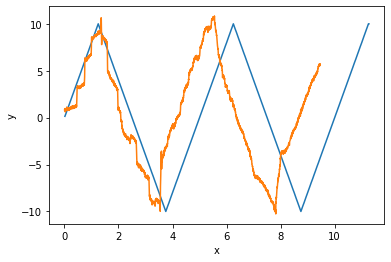

In [188]:
import seaborn as sns
x= pd.read_csv('8_deg_per_sec_sti.csv')
sns.lineplot(x='x', y='y', data=x)

y = pd.read_csv('eight_deg.csv')

sns.lineplot(x='x1_PDPW112_left',y='y1_PDPW112_left',data=y)

In [165]:
y

,x1_PDPW102_right,y1_PDPW102_right,x2_PDPW102_right,y2_PDPW102_right,x1_PDPW112_left,y1_PDPW112_left,x2_PDPW112_left,y2_PDPW112_left,x1_PDQE102_right,y1_PDQE102_right,...,x2_PDQE115_right,y2_PDQE115_right,x1_PDPW111_left,y1_PDPW111_left,x2_PDPW111_left,y2_PDPW111_left,x1_PDPW107_left,y1_PDPW107_left,x2_PDPW107_left,y2_PDPW107_left
0,0.0033,-1.7339,0.0033,-0.9879,0.0033,0.8266,0.0033,0.7056,0.0033,-0.0806,...,0.0033,-0.9879,0.0033,-1.2097,0.0033,8.1048,0.0033,0.5040,0.0033,1.2097
1,0.0067,-1.6129,0.0067,-1.3508,0.0067,0.8468,0.0067,0.6250,0.0067,0.1613,...,0.0067,-0.9274,0.0067,-1.0685,0.0067,8.0343,0.0067,0.4032,0.0067,1.1895
2,0.0100,-1.6734,0.0100,-1.3911,0.0100,0.9274,0.0100,0.6855,0.0100,0.2016,...,0.0100,-0.8669,0.0100,-1.1492,0.0100,7.9637,0.0100,0.1613,0.0100,1.1895
3,0.0133,-1.5726,0.0133,1.1492,0.0133,0.8669,0.0133,0.7056,0.0133,0.0605,...,0.0133,-1.0081,0.0133,-1.1290,0.0133,7.8931,0.0133,0.3226,0.0133,0.9677
4,0.0167,-1.5524,0.0167,2.2782,0.0167,0.7460,0.0167,0.7056,0.0167,0.3427,...,0.0167,-0.8065,0.0167,-1.0887,0.0167,7.8226,0.0167,0.5444,0.0167,0.9073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
